# SCIENCE


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits

filter = ['Ha', 'Hb', 'g', 'r', 'i']
file_paths = {f: f'data/cleaned_calibrated/{f}_calibrated.fit' for f in filter}
filter_cmap = {'Ha': 'gnuplot2','Hb': 'pink','g': 'bone','r': 'hot','i': 'copper'}
image = {}
sigma = {}

for f in filter:
    with fits.open(file_paths[f]) as hdul:
        image[f] = hdul[0].data
        header = hdul[0].header
        sigma[f] = hdul[0].header['sigma']

with fits.open('data/cleaned_calibrated/Ha_calibrated.fit'):
    params_ra = [header.get(f'RA_A{i}') for i in range(3)]
    params_dec = [header.get(f'DEC_B{i}') for i in range(3)]

def xy_to_radec(x, y):
    """
    Transform grid of (x, y) to (RA, Dec) coordinates.
    """
    ra = params_ra[0] + params_ra[1] * x + params_ra[2] * y
    dec = params_dec[0] + params_dec[1] * x + params_dec[2] * y
    return ra, dec

def radec_to_xy(ra, dec):
    A = np.array([[params_ra[1], params_ra[2]],
                  [params_dec[1], params_dec[2]]])
    b = np.array([ra - params_ra[0], dec - params_dec[0]])
    # Solve the linear system A * [x, y] = b
    x, y = np.linalg.solve(A, b)
    return x, y

stars_astrometry = []

with fits.open("data/astrometry.fit") as hdul:
    if len(hdul) > 1:
        table_hdu = hdul[1]  

        if table_hdu.data.ndim == 1:
            table = np.stack(table_hdu.data)

        for row in table:
            stars_astrometry.append({'ra': row[0], 'dec': row[1], 'x': row[2], 'y': row[3]})

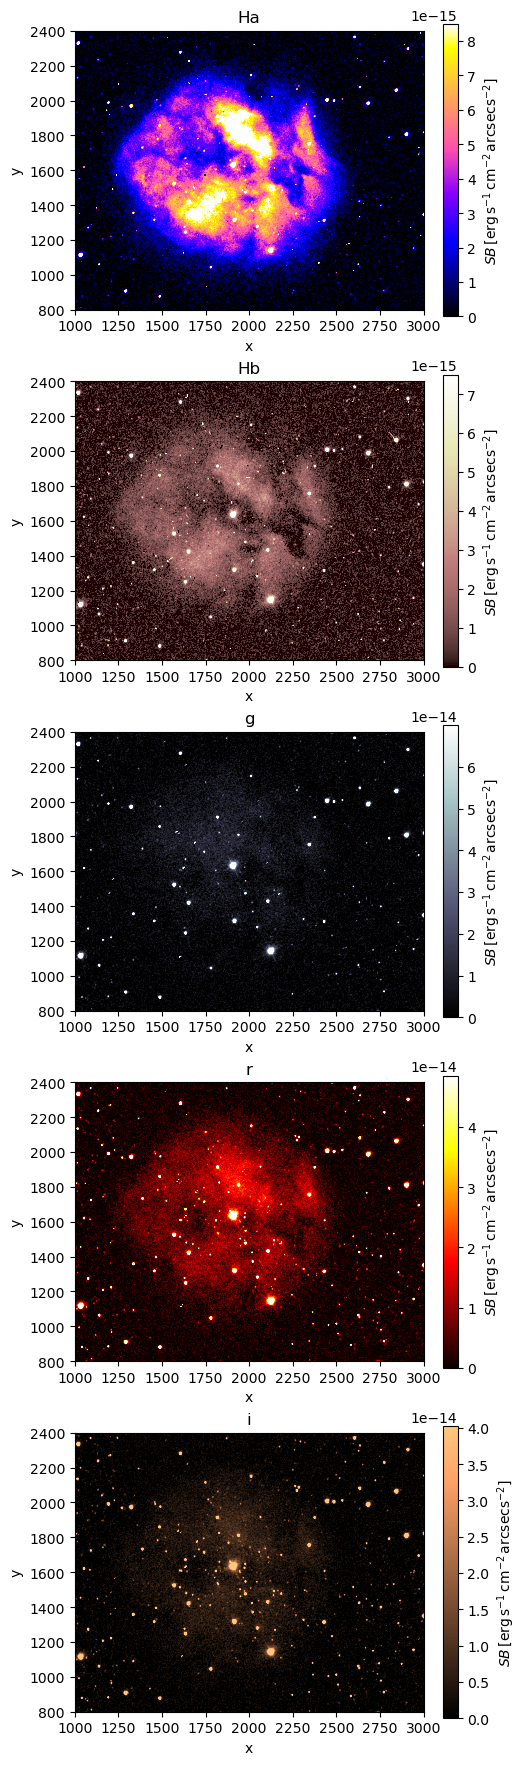

In [3]:
fig, axes = plt.subplots(5, 1, figsize=(5, 22))  
#fig.suptitle("Calibrated Science Frames with Specific Flux")
axes = axes.flatten()  # Ensure axes is a flat iterable list

ny, nx = image['Ha'].shape

for i, f in enumerate(filter):
    im = axes[i].imshow(image[f], clim=[0, np.quantile(image[f], 0.99)], cmap=filter_cmap[f], origin='lower')
    plt.colorbar(im, ax=axes[i], location='right', fraction=0.05, pad=0.05,
                 label="$SB \\, [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, arcsecs^{-2}}]$")
    axes[i].set_title(f)
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].set_xlim(1000,3000)
    axes[i].set_ylim(800,2400)

#plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to prevent overlap with title
plt.show()


Ha: emission due to recombination of hydrogen atoms 3->2 
Hb: emission 4->2 
r : we are actually still seeing Ha (r broadband filter include Ha)
g : we see Hb in g broad filter
i : stellar light DIFFUSED by the nebula

# CASE 1: Balmer decrements 

***Radiative transfer equation for optically thin sphere***:

The radiative transfer equation (with no diffusion involved) tells:

$$dI_\lambda = -I_\lambda\alpha_\lambda ds + j_\lambda ds$$

where the specific emissivity is a function of the ionized fraction (that we will assume 1 inside all nebula), the proton number density and the temperature:

$$j_\lambda = x^2 n_H^2 \alpha_\lambda(T)\frac{hc}{\lambda}$$

$\alpha_\lambda(T)$ is part of the effective recombination coefficient, and for $T\sim 10^4 \ \text{K}$, typical for an HII region, is $10^{-13} \mathrm{cm^3 \ s^{-1}}$ for $H\alpha$ line. The emissivity $j$ is measured in $\mathrm{erg \ s^{-1} cm^{-2} \ sterad^{-1}}$. 
Moreover we need to convert sterad to $\text{arcsec}^2$: $1 \ \text{sterad} = (206265 \text{arcsec})^2$.


For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = \int j  ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2}   j R_\text{cloud}\sin(\theta)d\theta = 2 j R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} sin(\theta)$ is the projected radius in the sky. 

However, if we consider dust absorption the full radiative transfer equation must be considered:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

where the dust optical depth is:

$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} \int n_\text{gas}ds = \sigma_{\lambda,H} \, n_H \, s = \sigma_{\lambda,H} N_H$$

for uniform hydrogen density and well mixed dust and gas. We will assume typical Milky Way conditions with an average Galactic extinction curve. Dust and hydrogen are well mixed and the absorption from dust depends on the hydrogen column density $N_H$. For uniform $n_H$:

We get: 

$$I_\lambda(s) = \sigma_{\lambda,H} n_H \int_0^{s} e^{-\sigma_{\lambda,H}n_H(s-s')} \frac{j_\lambda}{\sigma_{\lambda,H}n_H} ds' = j_\lambda\int_0^{s} e^{-\sigma_{\lambda,H}n_H(s-s')}ds' = \frac{j_\lambda}{\sigma_{\lambda,H}\,n_H}\left(1-e^{-\sigma_{\lambda,H} n_H s}    \right)$$

**Balmer decrements**

Dust absorption depends strongly on the wavelenght. 

$$\frac{I(H\alpha)}{I(H\beta)}(s) = \frac{I(H\alpha)}{I(H\beta)} \cdot \frac{\sigma_{H\beta,H}}{\sigma_{H\alpha,H}} \cdot \frac{ \left(1 - e^{-\sigma_{H\alpha,H} n_H s}\right)}{\left(1 - e^{-\sigma_{H\beta,H} n_H s}\right)}$$

The ratio of the emissivities depends only on the temperature, that we can assume $T\sim 10^4$ K. It is 2.86.




## DUST

The Calzetti Law is an empirical attenuation law used in astrophysics to describe the wavelength-dependent extinction of light caused by dust in starburst galaxies. It quantifies how dust absorbs and scatters light as a function of wavelength, providing a way to correct observed spectral energy distributions (SEDs) for dust attenuation effects.

$A_\lambda$ is the DUST LAW and it's the attenuation at wavelength $\lambda$ (in magnitudes):

$$A_\lambda = k(\lambda)E(B-V)$$

UV Steepness: The law shows steep attenuation in the ultraviolet (UV) range, reflecting strong dust effects in the UV part of the spectrum.

Broad Application: Primarily derived for starburst galaxies, but often used as a general correction for dust attenuation in galaxies.

Difference from Galactic Extinction Laws: Compared to laws like the Milky Way extinction curve, the Calzetti law lacks features such as the 2175 Å bump (a prominent absorption feature in the Milky Way extinction law).








# CASE 1: Extract the surface brightness radial profile and test radiative transfer equation

***Radiative transfer equation for optically thin sphere***:

The radiative transfer equation (with no diffusion involved) tells:

$$dI_\lambda = -I_\lambda\alpha_\lambda ds + j_\lambda ds$$

where the specific emissivity is a function of the ionized fraction (that we will assume 1 inside all nebula), the proton number density and the temperature:

$$j_\lambda = x^2 n_H^2 \alpha_\lambda(T)\frac{hc}{\lambda}$$

$\alpha_\lambda(T)$ is part of the effective recombination coefficient, and for $T\sim 10^4 \ \text{K}$, typical for an HII region, is $10^{-13} \mathrm{cm^3 \ s^{-1}}$ for $H\alpha$ line. The emissivity $j$ is measured in $\mathrm{erg \ s^{-1} cm^{-2} \ sterad^{-1}}$. 
Moreover we need to convert sterad to $\text{arcsec}^2$: $1 \ \text{sterad} = (206265 \text{arcsec})^2$.


For an optically thin spherical cloud (case B recombination: the cloud is optically thick only for Lyman continuum photons, but optically thin for all other transitions, like H$\alpha$ or H$\beta$):

$$SB(r) = \int j  ds = 2 \int_{\arcsin(r/R_\text{cloud})}^{\pi/2}   j R_\text{cloud}\sin(\theta)d\theta = 2 j R_\text{cloud} \sqrt{1-(\tfrac{r}{R_\text{cloud}})^2}$$

where $r = R_{cloud} sin(\theta)$ is the projected radius in the sky. 

However, if we consider dust absorption the full radiative transfer equation must be considered:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

where the dust optical depth is:


$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} \int n_\text{gas}ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} N_H = \sigma_{\lambda,H} N_H = \sigma_{\lambda,H} n_H s$$

for uniform hydrogen density and well mixed dust and gas. Here we have introduced dust cross section per hydrogen atom ...

$$I_\lambda(s) = \sigma_{\lambda,H} n_H \int_0^{s} e^{-\sigma_{\lambda,H}n_H(s-s')} \frac{j_\lambda}{\sigma_{\lambda,H}n_H} ds' = j_\lambda\int_0^{s'} e^{-\sigma_{\lambda,H}n_H(s-s')}ds'$$


In [30]:
# Extract surface brightness radial profile 

# TASK 1 subtract stars
# Mask stars

from astropy.modeling import models, fitting
from scipy.ndimage import median_filter

masked_Ha = np.copy(image['Ha'])  
masked_Hb = np.copy(image['Hb']) 

# This subtraction highlights stars while suppressing extended nebular structures, making it easier to detect and mask stars:
filtered_image = image['Ha'] - median_filter(image['Ha'], size=15)


In [31]:
for star in stars_astrometry:
    if 1000 < star['x'] < 3000 and 800 < star['y'] < 2400:
        
        l = 30
        rectangle = filtered_image[int(star['y'] - l):int(star['y'] + l), 
                                        int(star['x'] - l):int(star['x'] + l)]
        y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
        g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
        fit = fitting.LevMarLSQFitter()
        g_fit = fit(g_init, x, y, rectangle)
            
        refined_x = star['x'] - l + g_fit.x_mean.value
        refined_y = star['y'] - l + g_fit.y_mean.value

        sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
        fwhm_x = 2.355 * sigma_x
        fwhm_y = 2.355 * sigma_y
        fwhm = (fwhm_x + fwhm_y) / 2
        
        y, x = np.ogrid[:masked_image.shape[0], :masked_image.shape[1]] # circular aperture mask around the star

        # For a symmetric Gaussian, the flux has reduced by approximately 98.89% at 1.5×FWHM1.5×FWHM.
        if filtered_image[int(refined_x),int(refined_y)] < np.quantile(image['Ha'], 0.9999):
            mask_radius = 1.5 * fwhm 
        else:
            mask_radius = 5 * fwhm 
        mask = (x - refined_x)**2 + (y - refined_y)**2 <= mask_radius**2
        
        masked_Ha[mask] = 0
        masked_Hb[mask] = 0

#im = plt.imshow(masked_image, cmap=filter_cmap['Ha'],clim=[0, np.quantile(image['Ha'], 0.99)],origin='lower')
#plt.colorbar(im, location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

#center_x, center_y = radec_to_xy(328.370134,47.266320) 
#plt.scatter(center_x,center_y)
#plt.xlim(1800,2100)
#plt.ylim(1500,1700)

In [32]:

# Central star is BD+46 3474B (328.370134,47.266320) 
# https://simbad.u-strasbg.fr/simbad/sim-coo?&Coord=328.375681513405d47.263674788998d&CooFrame=FK5&Radius=2&Radius.unit=arcmin
center_x, center_y = radec_to_xy(328.370134,47.266320) 

# Define the inner and outer radii for the circular annuli such that each annulus contains the same number of pixels
num_annuli = 150
N = 10000
R_int_pixel = [0.1]
R_ext_pixel = []

for i in range(num_annuli):
    r_ext = np.sqrt(N/np.pi + R_int_pixel[-1]**2)  # Use the previous outer radius to define the next outer radius
    R_ext_pixel.append(r_ext)
    R_int_pixel.append(r_ext)

# Generate the list of annuli radii as tuples of inner and outer radii (PIXEL SPACE)
annuli_radii = [(R_int_pixel[i], R_ext_pixel[i]) for i in range(num_annuli)]  



# Average surface brightness in each annulus
from photutils.aperture import CircularAnnulus, aperture_photometry

average_surface_brightness_Ha = []
sigma_surface_brightness_Ha = []

average_surface_brightness_Hb = []
sigma_surface_brightness_Hb = []

balmer_decrement = []
balmer_decrement_error = []

for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)

    # Ha
    phot = aperture_photometry(masked_Ha, annulus, error = np.full(masked_image.shape, sigma['Ha']))
    I_Ha = phot['aperture_sum'][0]
    Ha_err = phot['aperture_sum_err'][0]
    average_surface_brightness_Ha.append(I_Ha / N)
    sigma_surface_brightness_Ha.append(Ha_err / N)

    # Hb
    phot = aperture_photometry(masked_Hb, annulus, error = np.full(masked_image.shape, sigma['Hb']))
    I_Hb = phot['aperture_sum'][0]
    Hb_err = phot['aperture_sum_err'][0]
    average_surface_brightness_Hb.append(I_Hb / N)
    sigma_surface_brightness_Hb.append(Hb_err / N)

    balmer_decrement.append(I_Ha/I_Hb)
    propagated_error = np.sqrt((Ha_err/I_Hb)**2 + (I_Ha/I_Hb**2 * Hb_err )**2)
    balmer_decrement_error.append(propagated_error)




In [62]:
# MODELS

# phyisical constants
wavelength_Ha = 656.281e-7    # Ha line (cm)
m_H = 1.6726219e-24           # hydrogen mass (g)
h = 6.62607015e-27            # Planck's constant (erg·s)
c = 3.0e10                    # Speed of light (cm/s)
parsec = 3.086e18             # cm

# cloud parameters
distance = 714 * parsec
T = 6500                      # electron temperature [K]
beta_2 = 2e-10 * T**(-3/4)    # hydrogen recombination rate for n>=2 [cm^3 s^-1] 
n_H = 8.0e+2                  # Hydrogen number density typical for HII region [cm^-3]
sigma_H = 6.3e-18             # photoionization cross section [cm^2]
alpha_Ha = 1e-13              # Absorption coefficient for Halpha 
x = 1                         # ionized fraction
f = 0.002                       # filling factor

# dust parameters
sigma_dust_H_Ha = 3e-22
sigma_dust_H_Hb = 5e-22
# Assuming a standard dust-to-gas ratio for the Milky Way. 
# Extinction curve parameterization consistent with RV=3.1 (Cardelli, Clayton, & Mathis, 1989).

# emissivity
j_Ha = x**2 * n_H**2 * alpha_Ha * h*c / wavelength_Ha / 206265**2
j_Hb = j_Ha/2.86
#print(f"Emissivity j is: {j:.2e} erg s-1 cm-3 arcsec-2")

R_inner_void = 1 / 3437.75 * distance
R_cloud = 4 / 3437.75 * distance

# assuming homogeneous n_H = 1e2 cm^-3
from scipy.integrate import quad
def SB_model(r, j, f, sigma_dust, R_cloud, R_inner_void):
    s = np.where(r < R_inner_void, 
                 2 * R_cloud * np.sqrt(1 - (r / R_cloud) ** 2) - 2 * R_inner_void * np.sqrt(1 - (r / R_inner_void) ** 2),
                 2 * R_cloud * np.sqrt(1 - (r / R_cloud) ** 2))

    integrals = np.array([quad(lambda s_prime: np.exp(-sigma_dust * n_H * (s_val - s_prime)), 0, s_val)[0] for s_val in s])
    
    return j * f * integrals



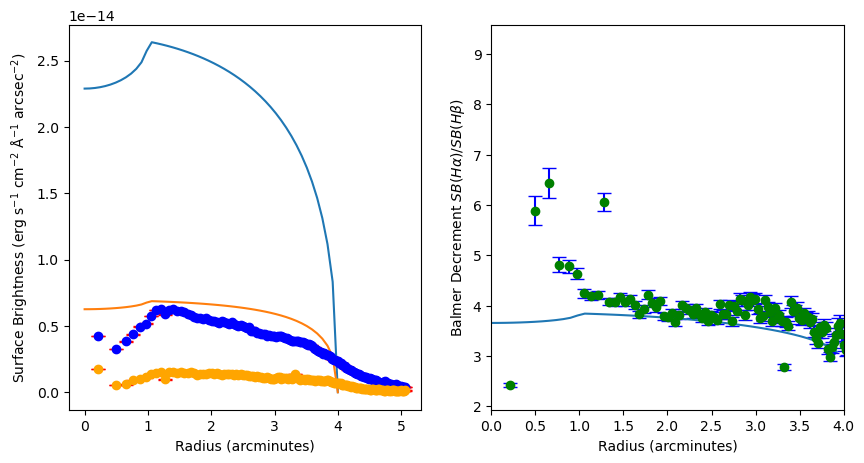

In [63]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

angular_size_pixel_TOBI_arcmin = 0.44 / 60 # arcmin per pixel
theta_r = np.array([(inner_r + outer_r) / 2 for inner_r, outer_r in annuli_radii]) * angular_size_pixel_TOBI_arcmin

ax[0].errorbar(theta_r, average_surface_brightness_Ha, yerr=sigma_surface_brightness_Ha, fmt='o', color='blue', 
             ecolor='red', capsize=5, linestyle='None')

ax[0].errorbar(theta_r, average_surface_brightness_Hb, yerr=sigma_surface_brightness_Hb, fmt='o', color='orange', 
             ecolor='red', capsize=5, linestyle='None')


ax[1].errorbar(theta_r, balmer_decrement, yerr=balmer_decrement_error, fmt='o', color='green', 
             ecolor='blue', capsize=5, linestyle='None')


ax[0].set_xlabel('Radius (arcminutes)')
ax[0].set_ylabel('Surface Brightness (erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$ arcsec$^{-2}$)')

ax[1].set_xlabel('Radius (arcminutes)')
ax[1].set_ylabel('Balmer Decrement $SB(H\\alpha)/SB(H\\beta)$')

ax[1].set_xlim(0,4)
#ax[1].set_ylim(2.83,4.25)
#plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
#plt.title('Surface Brightness Model')

## PLOT MODELS

r_grid = np.linspace(0,R_cloud)
theta_r_grid = r_grid / distance * 3437.75

ax[0].plot(theta_r_grid, SB_model(r_grid, j_Ha, f,sigma_dust_H_Ha, R_cloud, R_inner_void),
    label=rf"$j$ = {j_Ha:.1e}, $\sigma_{{\mathrm{{dust,H}}}}$ = {sigma_dust_H_Halpha:.2e}, "
          rf"$R_{{\mathrm{{cloud}}}}$ = {R_cloud / parsec:.2f} pc, "
          rf"$R_{{\mathrm{{inner}}}}$ = {R_inner_void / parsec:.2f} pc"
) 

ax[0].plot(theta_r_grid, SB_model(r_grid, j_Hb, f,sigma_dust_H_Hb, R_cloud, R_inner_void),
    label=rf"$j$ = {j_Hb:.1e}, $\sigma_{{\mathrm{{dust,H}}}}$ = {sigma_dust_H_Hb:.2e}, "
          rf"$R_{{\mathrm{{cloud}}}}$ = {R_cloud / parsec:.2f} pc, "
          rf"$R_{{\mathrm{{inner}}}}$ = {R_inner_void / parsec:.2f} pc"
) 

ax[1].plot(theta_r_grid, SB_model(r_grid, j_Ha, f,sigma_dust_H_Ha, R_cloud, R_inner_void)/SB_model(r_grid, j_Hb, f,sigma_dust_H_Hb, R_cloud, R_inner_void),
    label=rf"$j$ = {j_Hb:.1e}, $\sigma_{{\mathrm{{dust,H}}}}$ = {sigma_dust_H_Hb:.2e}, "
          rf"$R_{{\mathrm{{cloud}}}}$ = {R_cloud / parsec:.2f} pc, "
          rf"$R_{{\mathrm{{inner}}}}$ = {R_inner_void / parsec:.2f} pc"
) 

plt.show()


In [19]:
# Define an objective function to quantify the difference between the model and the observed data points. 
# A common choice is the chi-squared statistic or sum of squared residuals (SSR):

def objective(params, theta_r_grid, r_grid, theta_r, data, data_err):
    j, sigma_dust, R_cloud, R_inner_void = params
    model = SB_model(r_grid, j, sigma_dust, R_cloud, R_inner_void)
    residuals = (data - np.interp(theta_r, theta_r_grid, model)) / data_err
    return np.sum(residuals**2)

import emcee

# Initial guess and parameter bounds
initial_params = [0.2e-34, 1e-21, 5 / 3437.75 * distance, 1 / 3437.75 * distance]
ndim = len(initial_params)
nwalkers = 32
pos = initial_params + 1e-4 * np.random.randn(nwalkers, ndim)

# Define log-probability function (log-likelihood + priors)
def log_probability(params):
    j, sigma_dust, R_cloud, R_inner_void = params
    # Apply bounds to avoid unphysical values
    if not (0 < j < 1e-32 and 0 < sigma_dust < 1e-18 and 0 < R_cloud < 10 * parsec and 0 < R_inner_void < 10 * parsec):
        return -np.inf
    return -0.5 * objective(params, theta_r_grid, r_grid, theta_r, average_surface_brightness, sigma_surface_brightness)

# Initialize and run sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 5000, progress=True)

import corner
samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(samples, labels=[r"$j$", r"$\sigma_{\mathrm{dust,H}}$", r"$R_{\mathrm{cloud}}$", r"$R_{\mathrm{inner}}$"])


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

# CASE 2: the (dusty) Strömgren Sphere

Hot, massive O and B type stars emit consistently in the UV band and are therefore surrounded by regions of hot and fully ionized hydrogen, in many cases whith a spherical symmetry. These so called HII regions shine in emission, especially in $H\alpha$. 

In 1937 Bengt Strömgren derived a simple model for the radius of the ionized HII region, in practice imposing that the number of ionizing photons emitted by the central star balance the rate of recombination of hydrogen.

Ionizing Source: A hot star emits $S_*$​ ionizing photons per second ($h\nu>13.6$ eV). The number of ionizing photons can be computed knowing the star's surface temperature and radius, assuming perfect black body: 

$$S_*=4\pi R_*^2\int_0^{91.2} \frac{B(T_*,\lambda)}{hc/\lambda}d\lambda$$

Gas Cloud: The surrounding medium is composed of neutral hydrogen gas with density $n_H$ (assume uniform density).

Steady-State: The region reaches equilibrium where the rate of ionizations equals the rate of recombinations.

Recombination Coefficient: rate per unit volume is $\beta_2 n_p^2$​, where $\beta_2$​ is the case B recombination coefficient (accounts only for recombinations to levels $n\geq 2$, not ground state). $[\beta_2] = \text{cm}^3\text{s}^{-1}$ 

In equilibrium, the rate of ionizing photons emitted equals the rate of recombination within the ionized sphere:

$$S_*=\int_0^{R_S}\beta_2 n_p^2 4\pi r^2 dr = \beta_2n_H^2 \tfrac{4\pi}{3}R_S^3$$

assuming uniform $n_H$. From here:

$$R_S = \left(\frac{3S_*}{4\pi \beta_2 n_H^2}\right)^{1/3}$$

However this model doesn't take in account the fact that many surface brightness profiles that suggests that deep within HII regions, nearest to the star, gas has been depleted, most probably by stellar winds.

Correcting for this Stromgen radius becomes: 

$$R_S = \left(\frac{3S_*}{4\pi \beta_2 n_H^2}-R_\text{in}^3\right)^{1/3}$$

***Correcting for dust***

If dust with density $n_\text{dust}$ and cross-section $\sigma_\text{dust}$ is present: 

$$S_*=\int_{R_{in}}^{R_S}\beta_2 n_p^2 4\pi r^2 dr + \int_{R_{in}}^{R_S} \Gamma_\text{ph}(r) n_\text{dust} 4\pi r^2dr$$

where $\Gamma_\text{ph}(r)$ is the rate of absorption by dust, $[\Gamma_\text{ph}] = \text{s}^{-1}$. It can be expressed as a function of the flux of ionizing photons and of the dust cross section: $\Gamma_\text{ph} = \Phi_\text{ph}(r)e^{-\tau_\text{dust}(r)}\sigma_\text{dust}$, where $\Phi_\text{ph}(r) = N_\text{ph}/4\pi r^2$ and $\tau_\text{dust}(r) = \sigma_\text{dust}n_\text{dust}r$ accounts for the dust absorption.

Integrating:

$$S_* = \beta_2n_H^2 \tfrac{4\pi}{3}(R_S^3-R_{in}^3) + S_*\left(1-e^{-\sigma_\text{dust} n_\text{dust}(R_S-R_{in})}  \right)$$ 

We can define the dust cross section per hydrogen atom as $\sigma_\text{dust,H} = \tfrac{n_d}{n_H}\sigma_\text{dust}$. The dust to gas ratio is assumed to be uniform in HII regions. The typical value for $\sigma_\text{dust,H}$ in the Milky Way is $1.15 × 10^{−21} \text{cm}^2\text{/H}$.  

$$S_* = \beta_2n_H^2 \tfrac{4\pi}{3}(R_S^3-R_{in}^3) + S_*\left(1-e^{-\sigma_\text{dust,H} n_\text{H}(R_S-R_{in})}  \right)$$ 

or using the dust optical depth $\tau_\text{dust}=\sigma_\text{dust,H} n_\text{H}(R_S-R_{in})$, which is the optical depth due to dust corresponding to the Stromgen radius. The ultimate effect of dust is to reduce the number of ionizing photons of a factor $e^{-\tau_\text{dust}$.

The Stromgen radius is given by the trascendental equation: 

$$S_*e^{-\sigma_\text{dust,H} n_\text{H}(R_S-R_{in}} = \beta_2n_H^2 \tfrac{4\pi}{3}(R_S^3-R_{in}^3)$$ 


Reference:


https://en.wikipedia.org/wiki/Str%C3%B6mgren_sphere

https://www.astroscu.unam.mx/rmaa/RMxAA..51-2/PDF/RMxAA..51-2_aragaV.pdf

https://articles.adsabs.harvard.edu/pdf/1972ApJ...177L..69P

https://iopscience.iop.org/article/10.1086/317718/pdf

https://arxiv.org/pdf/1705.00269


In [40]:
# Extimate star ionizing photon rate

T_star = 30500                  # star surface temperature [K] 
R_sun = 6.96e10                 # solar radius in cm
R_star = 5.2 * R_sun            # star radius 

h = 6.62607015e-27              # Planck's constant (erg·s)
c = 3.0e10                      # Speed of light (cm/s)
k_B = 1.380649e-16              # Boltzmann's constant (erg/K)
Ly_break = 91.2e-7              # Lyman-break wavelength (cm)
wavelength_Ha = 656.281e-7      # Ha line (cm)

# Black body function in CGS units
def black_body(w):
    return (2 * h * c**2) / (w**5) * 1 / (np.exp((h * c) / (w * k_B * T_star)) - 1)

# Integration over wavelength to find the total number of ionizing photons emitted over 4 pi by the star
from scipy.integrate import quad
photons_area_time_sterad, _ = quad(lambda w: black_body(w) / (h * c / w), 0, Ly_break)

S = 4 * np.pi * R_star**2 * np.pi * photons_area_time_sterad    # Ionizing photon rate 
print("Ionizing photon rate is:", S, "s-1") 

Ionizing photon rate is: 6.538851058685966e+47 s-1


In [41]:
# STROMGEN RADIUS FOR VARIOUS VALUES OF DUST ABSORPTION

T_e = 6500                      # electron temperature [K]
beta_2 = 2e-10 * T_e**(-3/4)    # hydrogen recombination rate for n>=2 [cm^3 s^-1] 
n_H = 1.0e+2                    # Hydrogen number density typical for HII region [cm^-3]
sigma_H = 6.3e-18               # photoionization cross section [cm^2]
parsec = 3.086e18               # cm

sigma_dust_arr = np.array([1e-22,1e-21,2e-21,1e-20,1e-19])    # [cm^2/H]
sigma_H = 6.3e-18                                             # [cm^2] 

# trascendent equation to find the Stromgen radius
def trascendent_eq(R_S):
    return S * np.exp(-sigma_dust * n_H * (R_S-R_inner_void)) - beta_2 * n_H**2 * 4*np.pi/3 * (R_S**3 - R_inner_void**3)  

from scipy import optimize

stromgen_radius = []
tau_arr = []
for sigma_dust in sigma_dust_arr:

    # Use root_scalar to find the solution for R_S
    R_S = optimize.root_scalar(trascendent_eq, bracket=[1e16, 3e19], method='brentq').root
    tau = n_H*sigma_dust*(R_S-R_inner_void)
    tau_arr.append(tau)
    stromgen_radius.append(R_S)
    print(f"sigma_dust = {sigma_dust:.1e} cm^2/H, tau = {tau:.1f}, stromgen radius = {R_S/parsec:.2f} pc")
    

sigma_dust = 1.0e-22 cm^2/H, tau = 0.0, stromgen radius = 1.23 pc
sigma_dust = 1.0e-21 cm^2/H, tau = 0.3, stromgen radius = 1.13 pc
sigma_dust = 2.0e-21 cm^2/H, tau = 0.5, stromgen radius = 1.05 pc
sigma_dust = 1.0e-20 cm^2/H, tau = 1.6, stromgen radius = 0.73 pc
sigma_dust = 1.0e-19 cm^2/H, tau = 4.1, stromgen radius = 0.34 pc


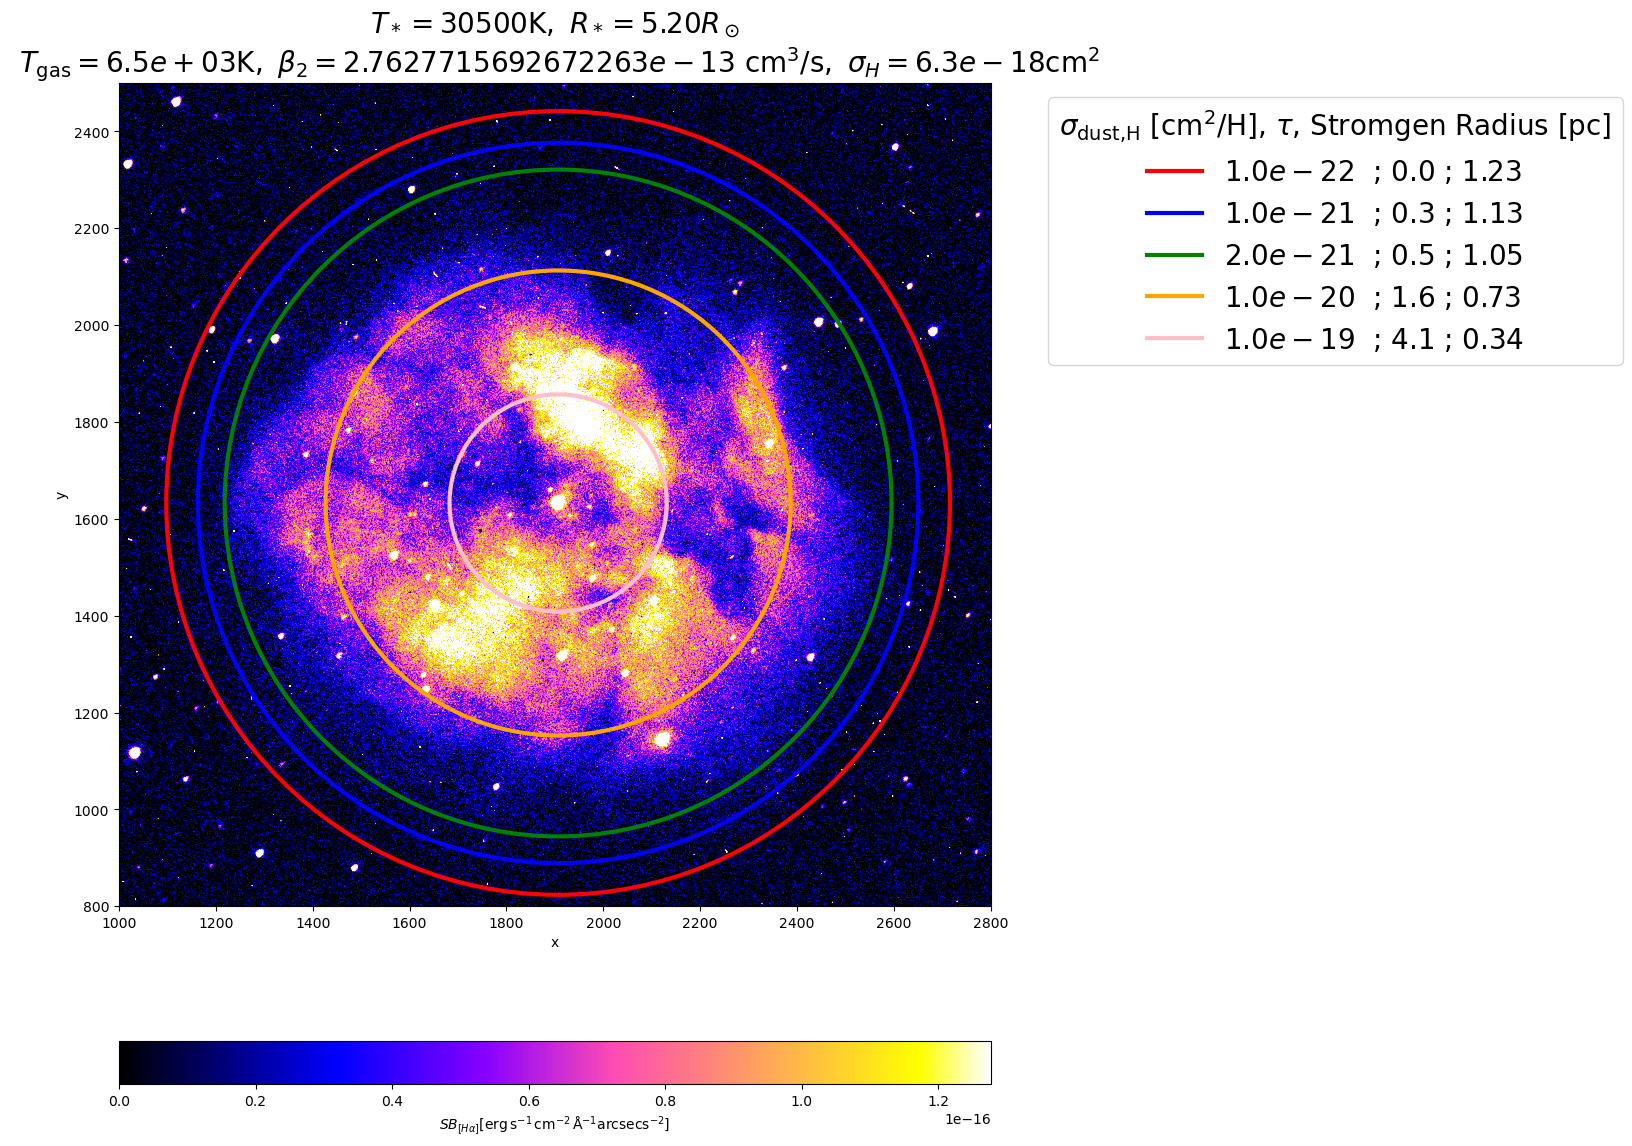

In [42]:
fig, ax = plt.subplots(figsize=(15,15))

im = ax.imshow(image['Ha'], clim=[0,np.quantile(image['Ha'], 0.99)], cmap=filter_cmap['Ha'] , origin='lower')
plt.colorbar(im, ax = ax, location='bottom', fraction=0.0375, pad=0.1, 
             label="$SB_{[H\\alpha]} [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

from matplotlib.patches import Circle
from matplotlib.lines import Line2D

distance = 714 * parsec # cm (800 ± 80 pc is the distance of Cocoon nebula)
center_x, center_y = radec_to_xy(328.370134,47.266320) 
angular_size_pixel_TOBI = 0.44 # arcsec per pixel

# Generate a list of colors for the circles
colors = ['red','blue','green','orange','pink']

# For each Stromgen radius
for i, r in enumerate(stromgen_radius):
    theta_stromgen_arcsec = r / distance * 206265
    circle = Circle((center_x, center_y), radius=theta_stromgen_arcsec / angular_size_pixel_TOBI, 
                    fill=False, linewidth=3, linestyle='-',color=colors[i])  #
    ax.add_patch(circle)

# Create custom legend handles (for circles)
handles = [Line2D([0], [0], color=colors[i], lw=3, linestyle = '-',label=f"${sigma_dust_arr[i]:.1e}$  ; {tau_arr[i]:.1f} ; {r/parsec:.2f}") for i, r in enumerate(stromgen_radius)]

# Add the legend outside the plot
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1), 
          title="$\sigma_\\text{dust,H}\ [\\text{cm}^2/\\text{H}]$, $\\tau$, Stromgen Radius [pc]",
         fontsize=20,title_fontsize=20)

ax.set_xlim(1000,2800)
ax.set_ylim(800,2500)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.title(f"$T_* = {T_star} \\mathrm{{K}}, \\ R_* = {R_star/R_sun:.2f} R_\odot$\n"
          f"$\\ T_{{\\mathrm{{gas}}}} = {T_e:.1e} \\mathrm{{K}}, \\ \\beta_2 = {beta_2} \\ \\mathrm{{cm}}^3 / \\mathrm{{s}}, \\ \\sigma_H = {sigma_H} \\mathrm{{cm}}^2$",
          fontsize=20)

plt.tight_layout()  # Adjust layout to make space for legend
plt.show()



***Radial profile of the ionized fraction***

So far we have proceeded with the assumption of uniform and full ionization inside the Stromgen sphere: $n_{HI}\ll n_{HII}$. This of course is not true near to the border of the sphere. If we drop this assumption, the optical depth in previous equations becomes:

$$\tau = \tau_H + \tau_d = \int_0^R n_{\text{H\,I}} \sigma_H \, dR' + \int_0^R n_\text{H} \sigma_\text{dust,H} \, dR'$$

where $\tau_H = $ is the photoionization optical depth, $n_\text{dust}\sigma_\text{dust}=n_H\sigma_\text{dust,H}$. To obtain the radial stratification of the ionized hydrogen fraction $x = \tfrac{n_{HII}}{n_H}$ we write the photoionization equilibrium condition (we neglect collisional ionization):

$$\Gamma_\text{ion}n_H(1-x) = x^2n_H^2\beta_2$$

where $\Gamma_\text{ion}(r)=\tfrac{S_*}{4\pi r^2} e^{-\tau}\sigma_\text{H}$ does not include dust absorption. The equation for $x(r)$ can be solved numerically. 


Reference:


https://en.wikipedia.org/wiki/Str%C3%B6mgren_sphere

https://www.astroscu.unam.mx/rmaa/RMxAA..51-2/PDF/RMxAA..51-2_aragaV.pdf

https://articles.adsabs.harvard.edu/pdf/1972ApJ...177L..69P

https://iopscience.iop.org/article/10.1086/317718/pdf

https://arxiv.org/pdf/1705.00269

In [37]:
# Constants in cgs 

h = 6.62607015e-27      # Planck's constant (erg·s)
c = 3.0e10              # Speed of light (cm/s)
k_B = 1.380649e-16      # Boltzmann's constant (erg/K)
Ly_continuum = 91.2e-7  # Lyman-break wavelength (cm)
wavelength_Ha = 656.281e-7  # Ha line (cm)
parsec = 3.086e18       # cm

T_e = 6500                      # electron temperature [K]
alpha_Ha = 1e-13                # Absorption coefficient for Halpha 
beta_2 = 2e-10 * T_e**(-3/4)    # hydrogen recombination rate for n>=2 [cm^3 s^-1] 
n_H = 1.0e+2                    # Hydrogen number density typical for HII region [cm^-3]
#sigma_dust = 1.15e-21          # dust cross section per hydrogen atom [cm^2/H]
sigma_H = 6.3e-18               # photoionization cross section [cm^2]

R_in = 0.2*parsec



# Root-finding function: for given r, founds correspondent x solving equation f_root(r=param,x) = 0
# To compute tau a x(r) function must be already defined. This function will be updated recursively
 
def f_root(r, x, x_func):  
    if r > R_in:
        tau_r, _ = quad(lambda r_prime: n_H * ((1 - x_func(r_prime)) * sigma_H + sigma_dust), R_in, r, epsabs=1e-3, epsrel=1e-3)
    else:
        tau_r = 0
    return S / (4 * np.pi * r**2) * np.exp(-tau_r) * sigma_H * (1 - x) - x**2 * n_H * beta_2

# Define the iterative solver
# Solve for the ionization fraction profile x(r) iteratively

from scipy.optimize import fsolve
def solve_ionization_profile(r_max, num_points=40, tol=1e-3, max_iter=100):   #sigma_dust

    r_array = np.linspace(0, r_max, num_points)
    x_array = np.ones_like(r_array)  # Initial guess: fully ionized (x = 1 everywhere)
    
    for iteration in range(max_iter):
        # Define x_func as an interpolator for the current x_array
        x_func = lambda r: np.interp(r, r_array, x_array)
    
        # Solve for x at each radius
        x_new = np.zeros_like(x_array)
        for i, r in enumerate(r_array):
            x_new[i] = fsolve(lambda x: f_root(r,x,x_func), x_array[i])[0]
    
        # Convergence ? 
        if np.max(np.abs(x_new - x_array)) < tol:
            break
        x_array = x_new
    else:
        print("Warning: Did not converge.")    
    return r_array, x_array


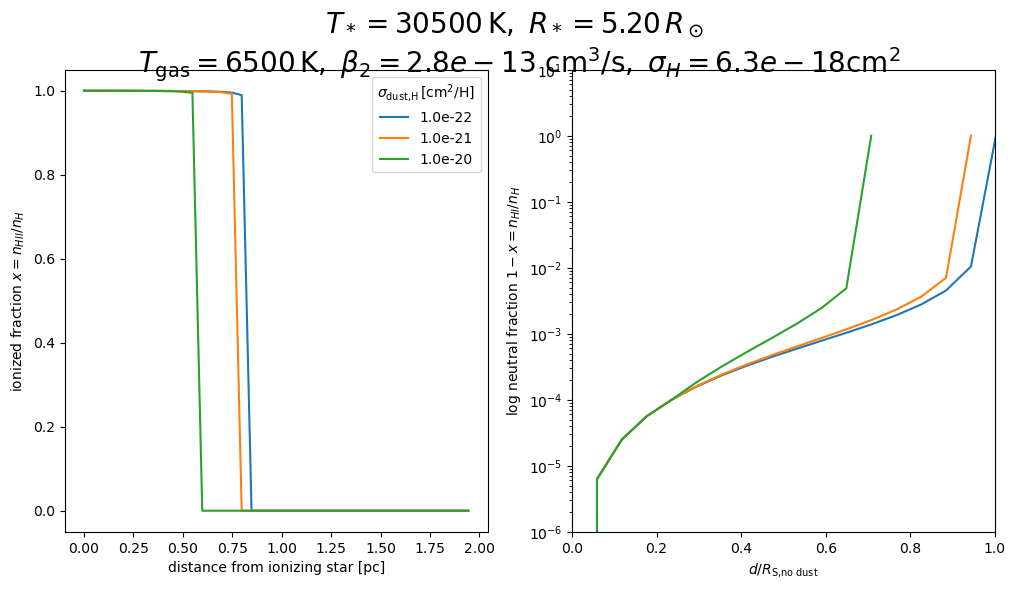

In [39]:

# PLOT

fig, ax = plt.subplots(1,2,figsize=(12,6))

sigma_dust_arr = [1e-22,1e-21,1e-20]
stromgren_no_dust = (3*S/(4*np.pi*beta_2*n_H**2) - R_in**3)**(1/3)

for sigma_dust in sigma_dust_arr:

    # Solve for x(r)
    r_max = 0.6e19  # Maximum radius to consider (cm)
    r_array, x_array = solve_ionization_profile(r_max)

    ax[0].plot(r_array/parsec,x_array,label=f"{sigma_dust:.1e}")
    y = r_array/stromgren_no_dust
    nf = np.ones_like(x_array)-x_array
    ax[1].plot(y[nf<1],nf[nf<1],label=f"{sigma_dust:.1e}")  

ax[0].set_xlabel("distance from ionizing star [pc]")
ax[0].set_ylabel("ionized fraction $x = n_{HII}/n_H$")

ax[1].set_yscale("log")
ax[1].set_xlim(0,1)
ax[1].set_ylim(1e-6,1e1)

ax[1].set_xlabel("$d/R_\\text{S,no dust}$")
ax[1].set_ylabel("log neutral fraction $1-x = n_{HI}/n_H$")


fig.suptitle(f"$T_* = {T_star} \, \\mathrm{{K}}, \\ R_* = {R_star/R_sun:.2f} \, R_\odot$\n"
          f"$\\ T_{{\\mathrm{{gas}}}} = {T_e}\, \\mathrm{{K}}, \\ \\beta_2 = {beta_2:.1e} \\ \\mathrm{{cm}}^3 / \\mathrm{{s}}, \\ \\sigma_H = {sigma_H} \\mathrm{{cm}}^2$",
          fontsize=20)
ax[0].legend(loc='upper right', title="$\sigma_\\text{dust,H} \, [\\text{cm}^2/\\text{H}]$" ) #, bbox_to_anchor=(1.05, 1)

plt.show()



In [26]:
# Constants in cgs 

h = 6.62607015e-27      # Planck's constant (erg·s)
c = 3.0e10              # Speed of light (cm/s)
k_B = 1.380649e-16      # Boltzmann's constant (erg/K)
Ly_continuum = 91.2e-7  # Lyman-break wavelength (cm)
wavelength_Ha = 656.281e-7  # Ha line (cm)
parsec = 3.086e18       # cm

T_e = 6500                      # electron temperature [K]
alpha_Ha = 1e-13                # Absorption coefficient for Halpha 
beta_2 = 2e-10 * T_e**(-3/4)    # hydrogen recombination rate for n>=2 [cm^3 s^-1] 
n_H = 1.0e+2                    # Hydrogen number density typical for HII region [cm^-3]
#sigma_dust = 1.15e-21          # dust cross section per hydrogen atom [cm^2/H]
sigma_H = 6.3e-18               # photoionization cross section [cm^2]



In [ ]:
# Root-finding function: for given r, founds correspondent x solving equation f_root(r=param,x) = 0
# To compute tau a x(r) function must be already defined. This function will be updated recursively
 
def f_root(r, x, x_func):  
    if r > R_in:
        tau_r, _ = quad(lambda r_prime: n_H * ((1 - x_func(r_prime)) * sigma_H + sigma_dust), R_in, r, epsabs=1e-3, epsrel=1e-3)
    else:
        tau_r = 0
    return S / (4 * np.pi * r**2) * np.exp(-tau_r) * sigma_H * (1 - x) - x**2 * n_H * beta_2

# Define the iterative solver
# Solve for the ionization fraction profile x(r) iteratively
def solve_ionization_profile(r_max, num_points=40, tol=1e-3, max_iter=100):   #sigma_dust

    r_array = np.linspace(0, r_max, num_points)
    x_array = np.ones_like(r_array)  # Initial guess: fully ionized (x = 1 everywhere)
    
    for iteration in range(max_iter):
        # Define x_func as an interpolator for the current x_array
        x_func = lambda r: np.interp(r, r_array, x_array)
    
        # Solve for x at each radius
        x_new = np.zeros_like(x_array)
        for i, r in enumerate(r_array):
            x_new[i] = optimize.fsolve(lambda x: f_root(r,x,x_func), x_array[i])[0]
    
        # Convergence ? 
        if np.max(np.abs(x_new - x_array)) < tol:
            break
        x_array = x_new
    else:
        print("Warning: Did not converge.")    
    return r_array, x_array


stromgen_radius = []
for sigma_dust in sigma_dust_arr:

    # Use root_scalar to find the solution for R_S
    R_S = root_scalar(trascendent_eq, bracket=[1e16, 3e19], method='brentq').root
    stromgen_radius.append(R_S)
    print(f"sigma_dust = {sigma_dust:.1e} cm^2/H, stromgen radius = {R_S/parsec:.2f} pc")
    
    # Solve for x(r)
    r_max = 0.6e19  # Maximum radius to consider (cm)
    r_array, x_array = solve_ionization_profile(r_max)

    ax[0].plot(r_array/parsec,x_array,label=f"{sigma_dust:.1e}")
    y = r_array/stromgen_no_dust
    nf = np.ones_like(x_array)-x_array
    ax[1].plot(y[nf<1],nf[nf<1],label=f"{sigma_dust:.1e}")  

ax[0].set_xlabel("distance from ionizing star [pc]")
ax[0].set_ylabel("ionized fraction $x = n_{HII}/n_H$")

ax[1].set_yscale("log")
ax[1].set_xlim(0,1)
ax[1].set_ylim(1e-6,1e1)

ax[1].set_xlabel("$d/R_\\text{S,no dust}$")
ax[1].set_ylabel("log neutral fraction $1-x = n_{HI}/n_H$")


fig.suptitle(f"$T_* = {T_star} \, \\mathrm{{K}}, \\ R_* = {R_star/R_sun:.2f} \, R_\odot$\n"
          f"$\\ T_{{\\mathrm{{gas}}}} = {T_e}\, \\mathrm{{K}}, \\ \\beta_2 = {beta_2:.1e} \\ \\mathrm{{cm}}^3 / \\mathrm{{s}}, \\ \\sigma_H = {sigma_H} \\mathrm{{cm}}^2$",
          fontsize=20)
ax[0].legend(loc='upper right', title="$\sigma_\\text{dust,H} \, [\\text{cm}^2/\\text{H}]$" ) #, bbox_to_anchor=(1.05, 1)

plt.show()


# DUST

The Calzetti Law is an empirical attenuation law used in astrophysics to describe the wavelength-dependent extinction of light caused by dust in starburst galaxies. It quantifies how dust absorbs and scatters light as a function of wavelength, providing a way to correct observed spectral energy distributions (SEDs) for dust attenuation effects.

$A_\lambda$ is the DUST LAW and it's the attenuation at wavelength $\lambda$ (in magnitudes):

$$A_\lambda = k(\lambda)E(B-V)$$

UV Steepness: The law shows steep attenuation in the ultraviolet (UV) range, reflecting strong dust effects in the UV part of the spectrum.

Broad Application: Primarily derived for starburst galaxies, but often used as a general correction for dust attenuation in galaxies.

Difference from Galactic Extinction Laws: Compared to laws like the Milky Way extinction curve, the Calzetti law lacks features such as the 2175 Å bump (a prominent absorption feature in the Milky Way extinction law).


Absorption only: 

$$I_{\text{obs,}\lambda} = I_{\text{int,}\lambda} e^{-\tau_\lambda}$$ 

$$\tau_\lambda = \int \alpha_\lambda ds = \int n_\text{dust}\sigma_\lambda ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} \int n_\text{gas}ds = \sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} N_H = \sigma_{\lambda,H} N_H $$

The Calzetti law is related to the optical depth by:

$$\tau_\lambda = \frac{A_{\lambda}}{1.086}=\frac{k(\lambda)E(B-V)}{1.086}$$

We derive the dust absorption cross section per hydrogen atom:

$$\sigma_\lambda \frac{n_\text{dust}}{n_\text{gas}} = \sigma_{\lambda,H} = \frac{k(\lambda)}{1.086N_H/E(B-V)}$$

where $N_H/E(B-V) = 5.8\times 10^{-21} \text{atoms/cm}^2\text{/mag}$ in the Milky Way.





Full radiative transfer equation for both emission and absorption:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$


$S_\lambda$ is the source function and is NOT a black body in this case: actually we are trating the gas + dust cloud as if it was made of only one kind of particle with emissivity the one of the gas and absorption entirely due to gas. Being that 

# BALMER DECREMENT

$$L_{obs}(\lambda) = L_{int}(\lambda)10^{-0.4A_\lambda} = L_{int}(\lambda)10^{-0.4k(\lambda)E(B-V)}$$

Reddening: $E(B-V) = (B-V)_{obs}-(B-V)_{int}$

The relationship between the nebular emission-line color excess and the Balmer decrement is given by:

$$E(B - V) = \frac{E(\mathrm{H}\beta - \mathrm{H}\alpha)}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} = \frac{2.5}{k(\lambda_{\mathrm{H}\beta}) - k(\lambda_{\mathrm{H}\alpha})} \log_{10} \left[ \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}} \right]$$

where $(k(\lambda_{\mathrm{H}\beta}))$ and $(k(\lambda_{\mathrm{H}\alpha}))$ are the reddening curves evaluated at $H\beta$ and $H\alpha$ wavelengths, respectively. The factor $E(\mathrm{H}\beta - \mathrm{H}\alpha)$ is analogous to the color excess but defined for $H\beta$ and $H\alpha$ instead of the B and V bands. Then, $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}$ is the observed Balmer decrement, and $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}}$ is the intrinsic or unreddened Balmer decrement, which is calculated theoretically.

The intrinsic Balmer decrement remains roughly constant for typical gas conditions in star-forming galaxies (see Osterbrock 1989). In our analysis, we assume the value of $(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{int}} = 2.86$, corresponding to a temperature $T = 10^4 \, \mathrm{K}$ and an electron density $n_e = 10^2 \, \mathrm{cm}^{-3}$ for Case B recombination (Osterbrock 1989). This choice is standard for star-forming galaxies in the literature. Thus, the nebular color excess is given by the following equation:

$$E(B - V) = 1.97 \log_{10} \left( \frac{(\mathrm{H}\alpha/\mathrm{H}\beta)_{\mathrm{obs}}}{2.86} \right)$$

### Case B Recombination:

***Lyman Continuum Photons are Reabsorbed***:
When a hydrogen atom recombines with an electron and transitions to the n=1 ground state, it emits a photon in the Lyman series (e.g., Lyman-α). Under Case B, these Lyman photons are absorbed and reprocessed within the gas, instead of escaping.
This reabsorption occurs because the gas is dense enough to be optically thick to ultraviolet photons in the Lyman series.

***Other Transitions are Optically Thin***:
Photons from transitions to levels n>1n (e.g., Hα from n=3→2) can escape the nebula without significant reabsorption.
This results in the prominence of Balmer, Paschen, and other series of hydrogen emission lines in the spectrum.

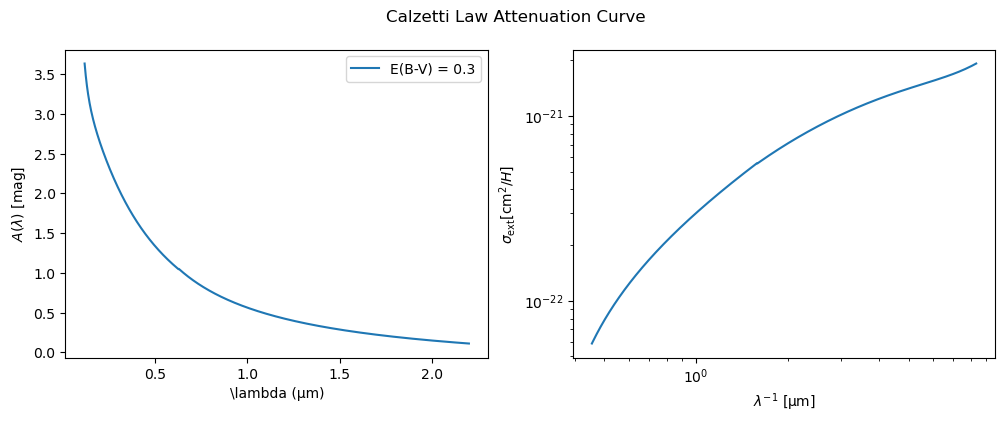

In [55]:
# Calzetti law for k(w)

def k_lambda(w,Rv=4.05):
    """
    Calzetti k(lambda)
    - wavelength: Wavelength array in microns (e.g., 0.1 to 2.2 microns).
    - Rv: Total-to-selective extinction ratio, default is 4.05.
    """
    w = np.atleast_1d(w) 
    k_lambda = np.zeros_like(w)
    
    # UV to optical range (0.12 ≤ λ ≤ 0.63 µm)
    #mask1 = (w >= 0.12) & (w <= 0.63)
    # EXTEND TO EXTREME UV
    mask1 = (w <= 0.63)
    k_lambda[mask1] = (
        2.659 * (-2.156 + 1.509 / w[mask1] - 0.198 / w[mask1]**2 + 0.011 / w[mask1]**3) + Rv
    )
    
    # Optical to near-IR range (0.63 ≤ λ ≤ 2.2 µm)
    mask2 = (w > 0.63) & (w <= 2.20)
    k_lambda[mask2] = 2.659 * (-1.857 + 1.040 / w[mask2]) + Rv

    return k_lambda
    

def Calzetti_dust_law(w,ebv,Rv=4.05):
    """
    Calzetti attenuation law for dust in starburst galaxies.
    - wavelength: Wavelength array in microns (e.g., 0.1 to 2.2 microns).
    - Rv: Total-to-selective extinction ratio, default is 4.05.
    -ebv: Ab - Av reddening
    """
    return k_lambda(w,Rv)*ebv

def sigma_dust_milky_way(w):
    """
    Dust cross section per hydrogen atom
    - wavelength: Wavelength array in microns (e.g., 0.1 to 2.2 microns).
    """
    return k_lambda(w)/(1.086 * 5.8e21)

# plot

fig,ax = plt.subplots(1,2,figsize=(12,4))

wavelengths = np.linspace(0.12, 2.2, 1000)  # Wavelengths in microns
ebv = 0.3  # Example color excess

ax[0].plot(wavelengths, Calzetti_dust_law(wavelengths, ebv), label=f"E(B-V) = {ebv}")
ax[0].set_xlabel("\lambda (µm)")
ax[0].set_ylabel("$A(\lambda)$ [mag]")
ax[0].legend()

ax[1].plot(1/wavelengths, sigma_dust_milky_way(wavelengths))
ax[1].set_xlabel("$\lambda^{-1}$ [µm]")
ax[1].set_ylabel("$\sigma_\\text{ext} [\\text{cm}^2/H]$")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

fig.suptitle("Calzetti Law Attenuation Curve")

plt.show()

In [57]:
print(sigma_dust_milky_way(91.1e-7*1e4))

[2.79577438e-21]


Full radiative transfer equation for both emission and absorption:

$$I_\lambda(\tau_\lambda) = I_{0,\lambda}e^{-\tau_\lambda} + \int_0^{\tau_\nu} e^{-(\tau_\nu-\tau_\nu')}S_\lambda(\tau_\lambda')d\tau'_\lambda$$

$S_\lambda$ is the source function and is NOT a black body in this case: actually we are trating the gas + dust cloud as if it was made of only one kind of particle with emissivity the one of the gas and absorption entirely due to gas. Being that 




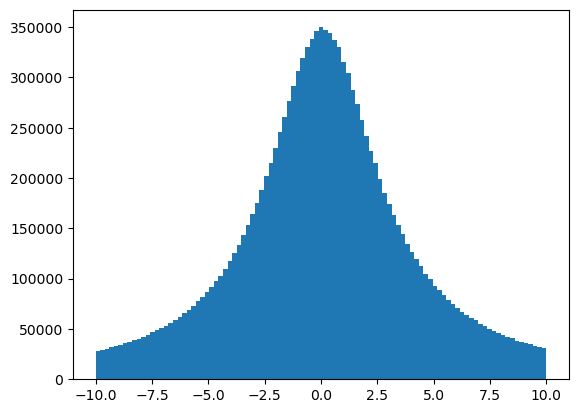

In [8]:
balmer_ratio = images_calib['Ha']/images_calib['Hb']
balmer_ratio_flat = balmer_ratio.flatten()
plt.hist(balmer_ratio_flat,bins=np.linspace(-10,10,100))
plt.show()


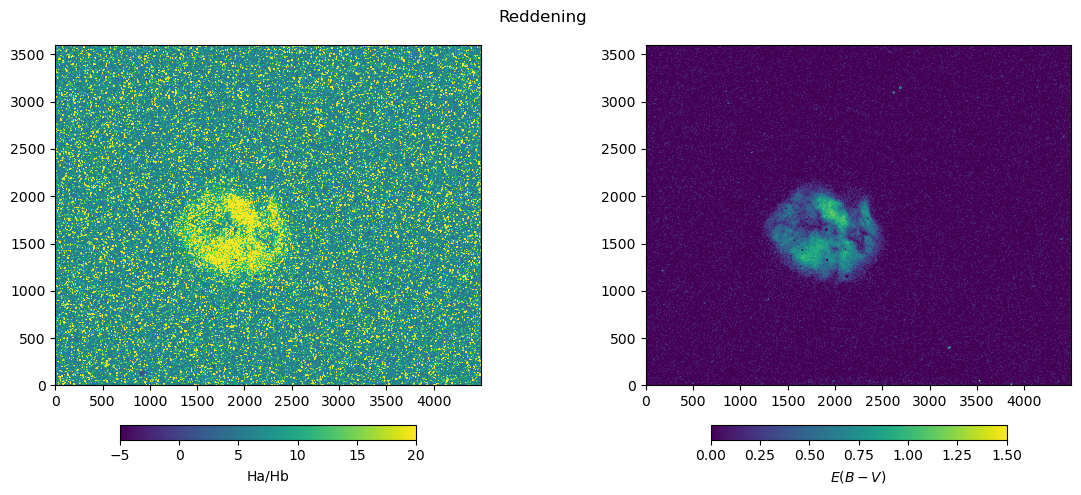

In [15]:
# map of the reddening factor over the nebula

ratio = images_calib['Ha']/images_calib['Hb']
ratio = np.where(ratio>0,ratio,2.86)
E_B_V = 1.97*np.log10(ratio/2.86)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Reddening")

im1 = axes[0].imshow(ratio, cmap='viridis', clim=[-5,20],origin='lower')
fig.colorbar(im1, ax=axes[0], location='bottom', fraction=0.0375, pad=0.1,label="Ha/Hb") #axes[0].set_title("$(H\alpha/H\beta)_{obs}$")

im2 = axes[1].imshow(E_B_V, cmap='viridis', clim=[0, 1.5], origin='lower')
fig.colorbar(im2, ax=axes[1], location='bottom', fraction=0.0375, pad=0.1, label="$E(B-V)$")  #axes[1].set_title("Balmer Decrement ($E(B-V)$)")

plt.tight_layout()
plt.show()



***Radial profile of the ionized fraction***

So far we have proceeded with the assumption of uniform and full ionization inside the Stromgen sphere: $n_{HI}\ll n_{HII}$. This of course is not true near to the border of the sphere. If we drop this assumption, the optical depth in previous equations becomes:

$$\tau = \tau_H + \tau_d = \int_0^R n_{\text{H\,I}} \sigma_H \, dR' + \int_0^R n_\text{H} \sigma_\text{dust,H} \, dR'$$

where $\tau_H = $ is the photoionization optical depth, $n_\text{dust}\sigma_\text{dust}=n_H\sigma_\text{dust,H}$. To obtain the radial stratification of the ionized hydrogen fraction $x = \tfrac{n_{HII}}{n_H}$ we write the photoionization equilibrium condition (we neglect collisional ionization):

$$\Gamma_\text{ion}n_H(1-x) = x^2n_H^2\beta_2$$

where $\Gamma_\text{ion}(r)=\tfrac{S_*}{4\pi r^2} e^{-\tau}\sigma_\text{H}$ does not include dust absorption. The equation for $x(r)$ can be solved numerically. 



In [ ]:
#alpha_dust, _ = quad(lambda w: black_body(w) * sigma_dust_milky_way(w * 1e4) / (h * c / w), 0, Ly_continuum) 
#print("alpha_dust is:", alpha_dust, "cm2 s-1") 

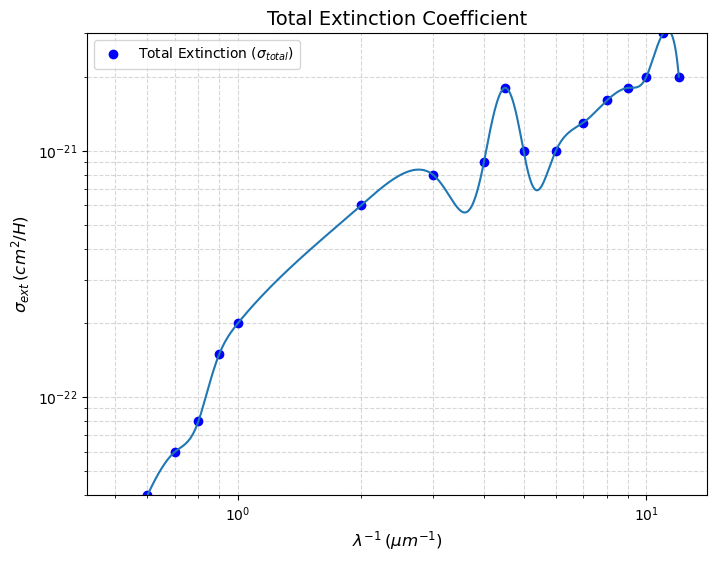

In [23]:
from scipy.interpolate import interp1d

# File format: lambda^-1 sigma_total
data = np.loadtxt("dust_extinction_curve.txt", unpack=True)
lambda_inv, sigma_total = data  # Unpack the columns


# Interpolation: Create an interpolating function
sigma_nu = interp1d(lambda_inv, sigma_total, kind="cubic")  # Cubic interpolation

plt.figure(figsize=(8, 6))
plt.plot(lambda_inv, sigma_total, label="Total Extinction ($\sigma_{total}$)", marker="o", linestyle="", color="blue")
w = np.linspace(min(lambda_inv), max(lambda_inv), 1000)
plt.plot(w,sigma_nu(w))


plt.ylim(4e-23,3e-21)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\\lambda^{-1} \\, (\\mu m^{-1})$", fontsize=12)
plt.ylabel("$\\sigma_{ext} \\, (cm^2 / H)$", fontsize=12)
plt.title("Total Extinction Coefficient", fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Show the plot
plt.show()


In [ ]:
# takes lambda^-1

def tau_nu(lambda_inv,dust_H_ratio,N_H):
    return sigma_nu(lambda_inv) * dust_H_ratio * N_H
    

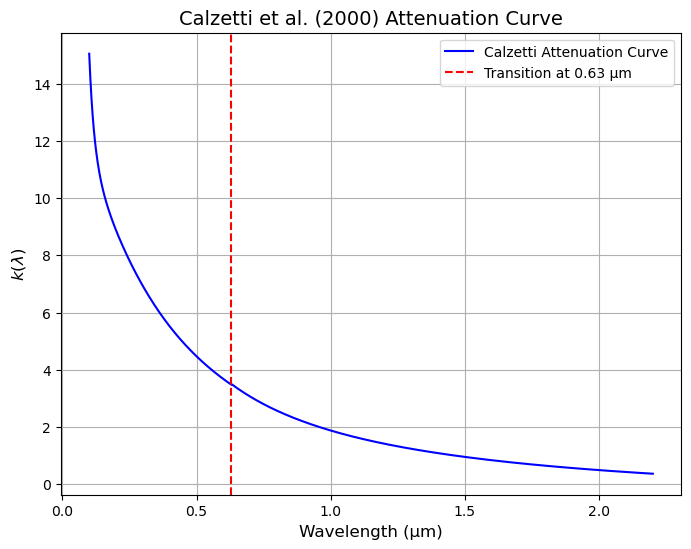

In [24]:
def calzetti_k_lambda(wavelength, R_V=4.05):
    """
    Calculate the Calzetti attenuation curve k(lambda).
    
    Parameters:
    - wavelength: Wavelength in microns (array or scalar).
    - R_V: Total-to-selective extinction ratio (default 4.05).
    
    Returns:
    - k_lambda: Attenuation curve at the given wavelengths.
    """
    wavelength = np.array(wavelength)
    k_lambda = np.zeros_like(wavelength)
    
    # UV regime: λ <= 0.63 μm
    uv_mask = wavelength <= 0.63
    k_lambda[uv_mask] = (
        2.659 * (-2.156 + 1.509 / wavelength[uv_mask] 
                 - 0.198 / wavelength[uv_mask]**2 
                 + 0.011 / wavelength[uv_mask]**3) + R_V
    )
    
    # Optical/NIR regime: λ > 0.63 μm
    optical_mask = wavelength > 0.63
    k_lambda[optical_mask] = (
        2.659 * (-1.857 + 1.040 / wavelength[optical_mask]) + R_V
    )
    
    return k_lambda

# Define wavelength range
wavelengths = np.linspace(0.1, 2.2, 1000)  # 0.1 μm to 2.2 μm
k_values = calzetti_k_lambda(wavelengths)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, k_values, label="Calzetti Attenuation Curve", color="blue")
plt.axvline(0.63, color="red", linestyle="--", label="Transition at 0.63 μm")
plt.xlabel("Wavelength (μm)", fontsize=12)
plt.ylabel("$k(\\lambda)$", fontsize=12)
plt.title("Calzetti et al. (2000) Attenuation Curve", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Does the central star saturates ? 

fig, ax = plt.subplots(1,2,figsize=(8,4))

from matplotlib.colors import LogNorm
im = ax[0].imshow(filtered_image, cmap=filter_cmap['Ha'],norm=LogNorm(vmin=1e-18, vmax=np.quantile(image['Ha'], 0.99999)),origin='lower')
plt.colorbar(im, ax = ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$SB  [\\mathrm{erg\\, s^{-1}\\, cm^{-2}\\, \u00c5^{-1} arcsecs^{-2}}]$")

center_x, center_y = radec_to_xy(328.370134,47.266320) 
l = 30
ax[0].set_xlim(center_x-l,center_x+l)
ax[0].set_ylim(center_y-l,center_y+l)

rectangle = filtered_image[int(center_y-l):int(center_y+l), int(center_x-l):int(center_x+l)]
y, x = np.mgrid[:rectangle.shape[0], :rectangle.shape[1]]
g_init = models.Gaussian2D(amplitude=rectangle.max(), x_mean=l, y_mean=l, x_stddev=5, y_stddev=5)
fit = fitting.LevMarLSQFitter()
g_fit = fit(g_init, x, y, rectangle)
            
refined_x = center_x - l + g_fit.x_mean.value
refined_y = center_y - l + g_fit.y_mean.value

sigma_x, sigma_y = g_fit.x_stddev.value, g_fit.y_stddev.value
fwhm_x = 2.355 * sigma_x
fwhm_y = 2.355 * sigma_y
fwhm = (fwhm_x + fwhm_y) / 2

# For 1,2,3 fwhm
from matplotlib.patches import Circle
for i in range(1,4):
    circle = Circle((center_x, center_y), radius=i*fwhm, fill=False, linewidth=3, linestyle='-')  #
    ax[0].add_patch(circle)

# Create custom legend handles (for circles)
#handles = [Line2D([0], [0], color=colors[i], lw=3, linestyle = '-',label=f"${sigma_dust_arr[i]:.1e}$  ; {tau_arr[i]:.1f} ; {r/parsec:.2f}") for i, r in enumerate(stromgen_radius)]


#Check if the computed PSF and the empirical PSF agree 
# Empirical PSF

center_x, center_y = radec_to_xy(328.370134,47.266320) 
r = np.arange(0.1,30.1,1)
annuli_radii = [(r[i], r[i+1]) for i in range(len(r) - 1)]

# Average surface brightness in each annulus to get the PSF
from photutils.aperture import CircularAnnulus, aperture_photometry

surface_brightness_central_star = []
for inner_r, outer_r in annuli_radii:

    annulus = CircularAnnulus((center_x, center_y), r_in=inner_r, r_out=outer_r)
    
    phot = aperture_photometry(filtered_image, annulus, error = np.full(masked_image.shape, sigma[f]))
    annulus_flux = phot['aperture_sum'][0]
    annulus_flux_err = phot['aperture_sum_err'][0]
    area_annulus = np.pi * (outer_r**2 - inner_r**2)
    surface_brightness_central_star.append(annulus_flux / area_annulus)
    #sigma_surface_brightness.append(annulus_flux_err / area_annulus)

ax[1].scatter(r[:-1], surface_brightness_central_star/max(surface_brightness_central_star))

from scipy.stats import norm
x = np.linspace(0,30)
gaus_pdf = norm.pdf(x,loc=0, scale=g_fit.x_stddev.value)
ax[1].plot(x,gaus_pdf/max(gaus_pdf),c='red')

plt.show()